# OCI Data Science - Merge

Before using this notebook user has to download neccessary data. We've collected/downloaded the data in advance by usiltizing `00 pull data.ipunb` notebook and saved them to `data` folder. This helps to save time though data-download may take a few hours.

This notebook creates final dataset which is utilized for model training and testing. The final data set will include the following features coming from different data sources:
1. Track info: Track length, racing laps, track name
2. Team info: driver name, positions
3. Weather data
4. Fuel consumption info: Estimated fuel consumption line's slop and bias
5. Tier degradation info: Estimated tire degradation line's slop and bias

The compute times repoted after execution of cells are based on utilizing compute shape = 2.8 (8 OCPU = 16vcpus).

## Contents:
* <a href='#intro'>Introduction</a>
* <a href='#weatherdata'>weather data</a>
* <a href='#lapsdata'>laps data</a>
* <a href='#resultdata'>results data</a>
* <a href='#Joindata'>merge weather and lap data</a>
* <a href='#plotsamplelapdata'>plot sample lap data</a>
* <a href='#Summarize'>Create Features for Train/Test Data</a>
* <a href='#AddTrackInfo'>Merge with Track Info</a>
* <a href='#DegLineAndfuelAdjustmnet'>Degradation Line and Fuel Adjustmnet</a>
    * <a href='#getLapsData'>Get Laps Data</a>
    * <a href='#normalizeFuel'>Calculate Fuel Consumption Line</a>
    * <a href='#CalculateDegSlopes'>Calculate Slope of deg line for different stints</a>
* <a href='#mergeLinesSlopAndBias'>Merge Lines' slop and bias</a>

<a id='intro'></a>
## Introduction

The data have already been saved in `data` folder. The data of intrest has `.pickle` extension and they are raw format which requires processing and preparing for feature extraction and model building.


#### Load packages

In [1]:
path = '/home/datascience/WorkSpace/RedBull-Racining-TimeToPit/notebooks'
data_path = '../../RedBull/data/'

In [2]:
import os
os.chdir(path)
import pandas as pd
import logging
import json
import pickle
import requests
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

<a id='weatherdata'></a>
## Weather Data
Weather data is available in session level and its time stamp is not aligned with laps-data.


In [3]:
file = open(data_path+'weathers_data.pickle','rb')
df_weather = pickle.load(file)
df_weather['eventYear'] = pd.DatetimeIndex(df_weather['EventDate']).year

<a id='resultdata'></a>
## Results

Load data and select.

Dropping non-race and non-qual rows from results data and keeping the following columns:
`'Position','FullName','Q1Sec','Q2Sec','Q3Sec','RoundNumber','EventName','eventYear','session','TimeSec'`

In [4]:
file = open(data_path+'results_data.pickle','rb')
df_res = pickle.load(file)

df_res['eventYear'] = pd.DatetimeIndex(df_res['EventDate']).year
df_res['Q1Sec'] = df_res['Q1']/np.timedelta64(1, 's')
df_res['Q2Sec'] = df_res['Q2']/np.timedelta64(1, 's')
df_res['Q3Sec'] = df_res['Q3']/np.timedelta64(1, 's')
df_res['TimeSec'] = df_res['Time']/np.timedelta64(1, 's')


## keep only race and qual data
df_res = df_res[(df_res['session']=='Race') | (df_res['session']=='Qualifying')]
print('-'*100,'\n', 'df_res size is: ', df_res.shape,'\n','-'*100,'\n')
print()

df_res= df_res[['Position','GridPosition','FullName','Q1Sec','Q2Sec','Q3Sec','RoundNumber','Abbreviation',
                'EventName','eventYear','session','Time','TimeSec','TeamName', 'EventDate']]


---------------------------------------------------------------------------------------------------- 
 df_res size is:  (3618, 27) 
 ---------------------------------------------------------------------------------------------------- 




<a id='lapsdata'></a>
## Laps Data

Load Lap data and convert times to useable format

In [5]:
file = open(data_path+'laps_data.pickle','rb')
drop_cols = ['Sector1Time','Sector2Time','Sector3Time',
             'Sector1SessionTime','Sector2SessionTime','Sector3SessionTime',
            'SpeedI1','SpeedI2','SpeedFL', 'IsAccurate']

df_laps = pickle.load(file).drop(drop_cols,axis=1).reset_index(drop=True)

df_laps['eventYear'] = pd.DatetimeIndex(df_laps['EventDate']).year
df_laps['lapTimeSec'] = df_laps['LapTime']/np.timedelta64(1, 's')


<a id='Joindata'></a>
### Merge weather and lap data

In [6]:
## Weather and Laps data are not time-aligned and each have their own 
## 
df_weather = df_weather.sort_values( ['EventName','eventYear','session', 'Time']).reset_index(drop=True)
df_laps = df_laps.sort_values( ['EventName','eventYear','session','Team','Driver', 'Time']).reset_index(drop=True)

LapsColumns = ['EventName','eventYear','Team','session','Driver',
               'Time', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime',
       'PitInTime', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife',
       'FreshTyre', 'LapStartTime', 'TrackStatus',
       'LapStartDate',  'country', 'EventDate','lapTimeSec']

In [7]:
%%time
def func_merger_lap_weather(d_f):
    '''
    func_merger_lap_weather method merges weather and laps data
    it returns all columns after merge
    '''    
    
    d_f = d_f.sort_values('Time').reset_index(drop=True)
    
    EventName = np.unique(d_f['EventName'])[0]
    session = np.unique(d_f['session'])[0]
    eventYear = np.unique(d_f['eventYear'])[0]
    Driver = np.unique(d_f['Driver'])
    
    sub_weather = df_weather[(df_weather['EventName']==EventName) &
                            (df_weather['session']==session) &
                            (df_weather['eventYear']==eventYear) ].sort_values('Time').reset_index(drop=True)
    
    sub_result = df_res[(df_weather['EventName']==EventName) &
                            (df_weather['session']==session) &
                            (df_weather['eventYear']==eventYear) ].sort_values('Time').reset_index(drop=True)
    
    d_f_merged = pd.merge_asof(d_f, sub_weather, 
                          on="Time", direction='nearest',
                         suffixes=('', '_drop'))
    d_f_merged.drop([col for col in d_f_merged.columns if 'drop' in col], axis=1, inplace=True)
    
#     print(d_f.shape,Driver, len(d_f_merged), EventName , eventYear, np.unique(d_f['Team']), 
#           session, len(df_weather))
    weather_cols = ['WindSpeed', 'AirTemp','Humidity', 'Pressure','TrackTemp','Rainfall','WindDirection']
    laps_cols = ['Time', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime', 'RoundNumber',
       'PitInTime', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife','FreshTyre', 'LapStartTime', 'TrackStatus',
       'LapStartDate',  'country', 'EventDate','lapTimeSec']
    laps_cols.extend(weather_cols) 
    
    return  d_f_merged[laps_cols]

df_lapWeather = df_laps.groupby(['EventName', 'eventYear','Team','session','Driver'])[LapsColumns].apply(func_merger_lap_weather).reset_index()

/home/datascience/conda/generalml_p37_cpu_v1/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


CPU times: user 11min 17s, sys: 915 ms, total: 11min 18s
Wall time: 11min 24s


<!-- <a id='plotsamplelapdata'></a>
### Plot a sample race lap-data -->

In [11]:
# sub_lap = df_lapWeather[(df_lapWeather['EventName']=='Austrian Grand Prix') &
#         (df_lapWeather['Team']=='Red Bull Racing') &
#         (df_lapWeather['session']=='Race') &
#        (df_lapWeather['eventYear']==2019) &
#         (df_lapWeather['Driver']=='VER')].sort_values('Time').reset_index(drop=True) #(df_laps['Driver']=='PER')

In [12]:
# fig = plt.figure(figsize=(12,2))
# plt.plot(sub_lap['LapNumber'],sub_lap['lapTimeSec'])
# plt.grid()
# plt.xlabel('Lap Number')
# plt.ylabel('Lap Time (Sec)')
# plt.title(sub_lap['EventName'][0]+ '   ' +
#           str(sub_lap['eventYear'].values[0])+ '   Driver: ' +
#           sub_lap['Driver'][0])

# fig = plt.figure(figsize=(12,2))
# plt.plot(sub_lap['LapNumber'],sub_lap['AirTemp'])
# plt.grid()
# plt.xlabel('Lap Number')
# plt.ylabel('Temp C')

# fig = plt.figure(figsize=(12,2))
# plt.plot(sub_lap['LapNumber'],sub_lap['Humidity'])
# plt.grid()
# plt.xlabel('Lap Number')
# plt.ylabel('Humidity %')

# plt.show()

In [13]:
df_lapWeather.columns

Index(['EventName', 'eventYear', 'Team', 'session', 'Driver', 'level_5',
       'Time', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime',
       'RoundNumber', 'PitInTime', 'SpeedST', 'IsPersonalBest', 'Compound',
       'TyreLife', 'FreshTyre', 'LapStartTime', 'TrackStatus', 'LapStartDate',
       'country', 'EventDate', 'lapTimeSec', 'WindSpeed', 'AirTemp',
       'Humidity', 'Pressure', 'TrackTemp', 'Rainfall', 'WindDirection'],
      dtype='object')

<a id='Summarize'></a>
## Summarize df_lapWeather and add GridPosition/Position: Create Features for Train/Test Data

In [14]:
%%time

lapWeatherCols = df_lapWeather.columns

def Features_PerTyre_PreRace_PerDriver(sub_df):
    
    bestTime=sessionName=meanAirTemp=meanTrackTemp=meanHumid=bestLapTimeSession=GridPosition=Position=TyreLife=Rainfall=np.nan  
    
    raceStintsNums = np.unique(sub_df['Stint'])[0]
    raceTyresComps = np.unique(sub_df['Compound'])
    Driver = np.unique(sub_df['Driver'])[0]
    eventYear = np.unique(sub_df['eventYear'])[0]
    EventName = np.unique(sub_df['EventName'])[0]
    RoundNumber =  np.unique(sub_df['RoundNumber'])[0]
    

    
    meanAirTemp = np.nanmean(sub_df['AirTemp']) #[sub_df['session']==sessionName] )
    meanTrackTemp = np.nanmean(sub_df['TrackTemp']) #[sub_df['session']==sessionName] )
    meanHumid = np.nanmean(sub_df['Humidity']) #[sub_df['session']==sessionName] )
    Rainfall = np.nanmean(sub_df['Rainfall'])#[sub_df['session']==sessionName] )
    
    GridPosition = df_res['GridPosition'][
                          (df_res['EventName']==EventName)&
                          (df_res['eventYear']==eventYear)&
                          (df_res['Abbreviation']==Driver)&
                          (df_res['RoundNumber']==RoundNumber)&
                          (df_res['session']=='Race')]

    Position = df_res['Position'][
                          (df_res['EventName']==EventName)&
                          (df_res['eventYear']==eventYear)&
                          (df_res['Abbreviation']==Driver)&
                          (df_res['RoundNumber']==RoundNumber)&
                          (df_res['session']=='Race')]
    if len(GridPosition): 
        GridPosition=GridPosition.values[0]
    if len(Position): 
        Position=Position.values[0]
        
    StintLen =[]
    StintLen = len(sub_df)
#     if len(raceStintsNums):
#         for ii in raceStintsNums:
#             StintLen.append(len(sub_df[sub_df['Stint']==ii]) )
    
        
    TyreAge = np.min(sub_df['TyreLife'])
    lapNumberAtBeginingOfStint = np.min(sub_df['LapNumber'])
    
    d_f = df_lapWeather[(df_lapWeather['EventName']==EventName)&
                        (df_lapWeather['eventYear']==eventYear)&
                        (df_lapWeather['Driver']==Driver)&
                        (df_lapWeather['RoundNumber']==RoundNumber)&
                        (df_lapWeather['session']=='Qualifying')&
                        (df_lapWeather['Compound']!='raceTyresComps')]
    
    if len(d_f)>0:
        
        bestTime = np.min(d_f['lapTimeSec'])
#         print(bestTime, np.unique(d_f['session']) )
        
        if ~np.isnan(bestTime):
            sessionName = np.unique(d_f['session'][d_f['lapTimeSec']==bestTime])[0]
         

    return pd.Series(data = [bestTime,sessionName, meanAirTemp, meanTrackTemp, meanHumid, Rainfall,
                             GridPosition,Position, raceStintsNums,TyreAge,lapNumberAtBeginingOfStint, StintLen], 
                     index=['bestPreRaceTime','bestLapTimeIsFrom','meanAirTemp','meanTrackTemp','meanHumid','Rainfall', 
                            'GridPosition','Position','raceStintsNums','TyreAge','lapNumberAtBeginingOfStint', 'StintLen'])

df_agg = df_lapWeather[df_lapWeather['session']=='Race'].groupby(['EventName','RoundNumber','eventYear','Team','Compound',
                                                            'Driver','Stint']).\
                                                            apply(Features_PerTyre_PreRace_PerDriver).reset_index()

CPU times: user 15min 5s, sys: 90.7 ms, total: 15min 5s
Wall time: 15min 12s


In [15]:
df_agg[df_agg['RoundNumber']==15].reset_index(drop=True).head(2)

,EventName,RoundNumber,eventYear,Team,Compound,Driver,Stint,bestPreRaceTime,bestLapTimeIsFrom,meanAirTemp,meanTrackTemp,meanHumid,Rainfall,GridPosition,Position,raceStintsNums,TyreAge,lapNumberAtBeginingOfStint,StintLen
0,Bahrain Grand Prix,15,2020,Alfa Romeo Racing,HARD,GIO,3.0,89.491,Qualifying,24.739394,26.430303,72.542424,0.0,16.0,16.0,3.0,1.0,21.0,33.0
1,Bahrain Grand Prix,15,2020,Alfa Romeo Racing,HARD,RAI,3.0,89.810,Qualifying,24.778261,26.578261,71.721739,0.0,17.0,15.0,3.0,1.0,18.0,23.0


<a id='AddTrackInfo'></a>
## Add track info

In [16]:
### Load track data
trackInfo = pd.read_csv(data_path+'circuit_length.csv')
df_agg = df_agg.merge(trackInfo, on=['EventName'])

In [22]:
df_agg[df_agg['RoundNumber']==15].reset_index(drop=True).head(2)

,EventName,RoundNumber,eventYear,Team,Compound,Driver,Stint,bestPreRaceTime,bestLapTimeIsFrom,meanAirTemp,...,meanHumid,Rainfall,GridPosition,Position,raceStintsNums,TyreAge,lapNumberAtBeginingOfStint,StintLen,CircuitLength,designedLaps
0,Bahrain Grand Prix,15,2020,Alfa Romeo Racing,HARD,GIO,3.0,89.491,Qualifying,24.739394,...,72.542424,0.0,16.0,16.0,3.0,1.0,21.0,33.0,5.412,57
1,Bahrain Grand Prix,15,2020,Alfa Romeo Racing,HARD,RAI,3.0,89.810,Qualifying,24.778261,...,71.721739,0.0,17.0,15.0,3.0,1.0,18.0,23.0,5.412,57


In [20]:
df_agg.to_csv('../data/semi_final_data.csv', index=False)

<a id='DegLineAndfuelAdjustmnet'></a>
# Tyre Degredation Line and Fuel Adjestmnet

Lap data is the primary source of this section.

## Subjects covered in the rest of this notebook:

* <a href='#intro'>Objectives and Introduction</a>
* <a href='#process'>Process</a>
    * <a href='#getLapsData'>Get Laps Data</a>
    * <a href='#normalizeFuel'>Fuel Consumption Rate</a>
    * <a href='#CalculateDegSlopes'>Calculate slope of Deg lines for different stints</a>
* <a href='#postrocessing'>Postprocessing</a>

<a id='getLapsData'></a>
## get laps Data

laps data is already loaded at earlier part of this notebook.
In case if user wants to execute the rest of this notebook before running prior cells then the following lines have to executed:

`df_agg = pd.read_csv('../data/semi_final_data.csv', index=False)`

`file = open(data_path+'laps_data.pickle','rb')`

`drop_cols = ['Sector1Time','Sector2Time','Sector3Time',
             'Sector1SessionTime','Sector2SessionTime','Sector3SessionTime',
            'SpeedI1','SpeedI2','SpeedFL', 'IsAccurate']`

`df_laps = pickle.load(file).drop(drop_cols,axis=1).reset_index(drop=True)`

`df_laps['eventYear'] = pd.DatetimeIndex(df_laps['EventDate']).year`

`df_laps['lapTimeSec'] = df_laps['LapTime']/np.timedelta64(1, 's')`

In [23]:
df_laps.columns

Index(['Time', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime',
       'PitInTime', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife',
       'FreshTyre', 'LapStartTime', 'Team', 'Driver', 'TrackStatus',
       'LapStartDate', 'RoundNumber', 'EventName', 'country', 'session',
       'EventDate', 'eventYear', 'lapTimeSec'],
      dtype='object')

In [24]:
"""
Create a column to identify laps with a large delat-time between to consequtive laps
In normal race condition delat-time between two consequitive laps 
"""

df_laps['large_delta_time'] = np.nan
df_laps['delta_lapTime'] = np.nan


## create a column for delta_lapTime'
df_laps['delta_lapTime'] = df_laps.groupby(['EventName','eventYear','Driver','session','Stint'])['lapTimeSec'].diff()


## label thoes are biger or smaller than +-2
df_laps['large_delta_time']= (df_laps['delta_lapTime']<2) & (df_laps['delta_lapTime']>-2)
print(sum(df_laps['large_delta_time']))

103135


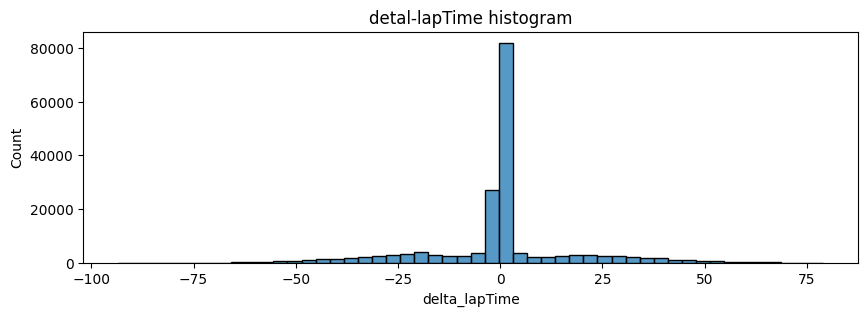

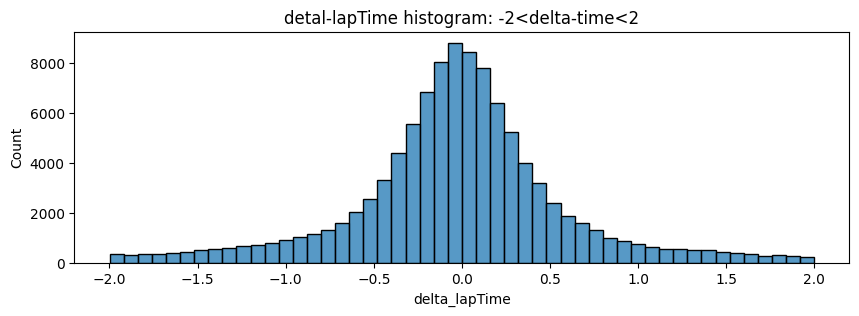

In [25]:
## detal-lapTime histogram without filtering
fig = plt.figure(figsize=(10,3))
sns.histplot(df_laps[df_laps['delta_lapTime'].notnull()],x = 'delta_lapTime', bins=50)
plt.title('detal-lapTime histogram')
plt.show()

fig = plt.figure(figsize=(10,3))
## detal-lapTime histogram with filtering
sns.histplot(df_laps[df_laps['large_delta_time']],x = 'delta_lapTime', bins=50)
plt.title('detal-lapTime histogram: -2<delta-time<2')
plt.show()

In [26]:
## calculate Stint length
df_stintLen = df_laps.groupby(['EventName','session', 'Driver', 'Stint']).size().reset_index(name='stintLength')
df = df_laps.merge(df_stintLen, on = ['EventName','session', 'Driver', 'Stint'])
print('-'*100,'\n', 'df_lap length: ',len(df_laps), '   ','df length is: ', len(df), '\n','-'*100)

## if the stint greater than 5 laps
df = df[(df['stintLength']>=6) & (df['session']=='Race')]
print('-'*100,'\n', 'df_lap length: ',len(df_laps), '   ','df length is: ', len(df), '\n','-'*100)

print('-'*100,'\n', 'Teams are: ',list(np.unique(df['Team']) ), '\n\n',
      'Event Years are: ', list(np.unique(df['eventYear']) ), '\n\n',
      'Drivers are: ', list(np.unique(df['Driver']) ), '\n','-'*100)

---------------------------------------------------------------------------------------------------- 
 df_lap length:  249793     df length is:  249793 
 ----------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------- 
 df_lap length:  249793     df length is:  96676 
 ----------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------- 
 Teams are:  ['Alfa Romeo', 'Alfa Romeo Racing', 'AlphaTauri', 'Alpine', 'Aston Martin', 'Ferrari', 'Force India', 'Haas F1 Team', 'McLaren', 'Mercedes', 'Racing Point', 'Red Bull Racing', 'Renault', 'Sauber', 'Toro Rosso', 'Williams'] 

 Event Years are:  [2018, 2019, 2020, 2021, 2022] 

 Drivers are:  ['AIT', 'ALB', 'ALO', 'BOT', 'ERI', 'FIT', 'GAS', 'GIO', 'GRO', 'HAM', 'HAR', 'HUL',

<a id='normalizeFuel'></a>
### Calculate Fuel Consumption Line
It is assumed that at the begining of the race, vehicle is loaded with 100Kg of fuel and at the end of the race the tank is empty.
Moreover it is assumed that fuel consumption is linear. we add a col to data for presenting this concept.

In [27]:
%%time
def func_fuelLine_sample_points(d_f):
    '''
    func method return avg of 3 lap-time after Stint and lapNum after Stint
    '''    
    # Preparing X and y data from the given data
    
    x = d_f['LapNumber'][(d_f['large_delta_time']) ].values
    y = d_f['lapTimeSec'][(d_f['large_delta_time']) ].values

    if len(x)<=3: 
        return pd.Series(data = [np.nan, np.nan], index = ['valueAfterStint','LapNumAfterStint'])
    
    # Calculating the parameters using the least square method
    mean_val = np.mean(y[0:3])
    ind = x[0]

    return pd.Series(data = [mean_val, ind], index = ['valueAfterStint','LapNumAfterStint'])


def func_fuelLine_params(d_f):
    '''
    func method fits a line to the to the data points (LapNumber, lapTimeSec) 
    which are collected immediately after each pit
    and returns line slope and bias.
    '''    
    # Preparing X and y data from the given data
    d_f.drop_duplicates(subset=['LapNumAfterStint','valueAfterStint'], keep='first', inplace=True)
    x = d_f['LapNumAfterStint'].values
    y = d_f['valueAfterStint'].values

    if (len(x)<2) | sum(np.isnan(x)) | sum(np.isnan(y)): 
        return pd.Series(data = [np.nan, np.nan], index = ['fuel_slope','fuel_bias'])
    
    # Calculating the parameters using the least square method
    theta = np.polyfit(x, y, 1)
    y_line = theta[1] + theta[0] * x

    return pd.Series(data = [theta[0], theta[1]], index = ['fuel_slope','fuel_bias'])

df_fuel_corr = df.groupby(['EventName','eventYear','session', 'Team','Driver', 'Stint']).apply(func_fuelLine_sample_points).reset_index()
df = df.merge(df_fuel_corr, on= ['EventName','eventYear','session', 'Team','Driver', 'Stint'])

df_theta = df.groupby(['EventName','eventYear','session', 'Team','Driver']).apply(func_fuelLine_params).reset_index() #name=['theta0','theta1']
df = df.merge(df_theta, on= ['EventName','eventYear','session', 'Team','Driver'])

print('\n','-'*100, '\n','df Length is: ', len(df), '\n','-'*100)


 ---------------------------------------------------------------------------------------------------- 
 df Length is:  96676 
 ----------------------------------------------------------------------------------------------------
CPU times: user 16.2 s, sys: 24.7 ms, total: 16.2 s
Wall time: 16.4 s


In [28]:
df.head()

,Time,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,SpeedST,IsPersonalBest,Compound,...,EventDate,eventYear,lapTimeSec,large_delta_time,delta_lapTime,stintLength,valueAfterStint,LapNumAfterStint,fuel_slope,fuel_bias
0,0 days 00:35:00.860000,99,NaT,1.0,1.0,0 days 00:00:07.934000,NaT,319.0,False,MEDIUM,...,2020-08-09,2020,NaN,False,NaN,7,95.157,3.0,-0.078449,94.746672
1,0 days 00:36:35.989000,99,0 days 00:01:35.129000,2.0,1.0,NaT,NaT,317.0,False,MEDIUM,...,2020-08-09,2020,95.129,False,NaN,7,95.157,3.0,-0.078449,94.746672
2,0 days 00:38:11.530000,99,0 days 00:01:35.541000,3.0,1.0,NaT,NaT,330.0,False,MEDIUM,...,2020-08-09,2020,95.541,True,0.412,7,95.157,3.0,-0.078449,94.746672
3,0 days 00:39:46.766000,99,0 days 00:01:35.236000,4.0,1.0,NaT,NaT,327.0,False,MEDIUM,...,2020-08-09,2020,95.236,True,-0.305,7,95.157,3.0,-0.078449,94.746672
4,0 days 00:41:21.460000,99,0 days 00:01:34.694000,5.0,1.0,NaT,NaT,325.0,False,MEDIUM,...,2020-08-09,2020,94.694,True,-0.542,7,95.157,3.0,-0.078449,94.746672


<a id='CalculateDegSlopes'></a>
## Calculate slope of deg line for different stints

In [29]:
%%time
def func_deg_line(d_f):
    '''
    func method fits a line to the stints' lapTime data and 
    returns line slope and bias.
    '''    
    # Preparing X and y data from the given data
    
    x = d_f['LapNumber'][(d_f['large_delta_time']) ].values
    y = d_f['lapTimeSec'][(d_f['large_delta_time']) ].values
    
    if len(x)<6: 
        return pd.Series(data = [np.nan, np.nan], index = ['deg_slope','deg_bias'])
    
    # Calculating the parameters using the least square method
    theta = np.polyfit(x[1:-2], y[1:-2], 1)
    y_line = theta[1] + theta[0] * x

    return pd.Series(data = [theta[0], theta[1]], index = ['deg_slope','deg_bias'])


df_theta = df.groupby(['EventName','eventYear','session', 'Team','Driver', 'Stint']).apply(func_deg_line).reset_index() #name=['theta0','theta1']
df = df.merge(df_theta, on= ['EventName','eventYear','session', 'Team','Driver', 'Stint'])
# df[df['sessions']=='Race'].tail(50)
print('\n','-'*100, '\n','df Length is: ', len(df), '\n','-'*100)


 ---------------------------------------------------------------------------------------------------- 
 df Length is:  96676 
 ----------------------------------------------------------------------------------------------------
CPU times: user 6.28 s, sys: 15.8 ms, total: 6.29 s
Wall time: 6.36 s


In [30]:
df.columns

Index(['Time', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime',
       'PitInTime', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife',
       'FreshTyre', 'LapStartTime', 'Team', 'Driver', 'TrackStatus',
       'LapStartDate', 'RoundNumber', 'EventName', 'country', 'session',
       'EventDate', 'eventYear', 'lapTimeSec', 'large_delta_time',
       'delta_lapTime', 'stintLength', 'valueAfterStint', 'LapNumAfterStint',
       'fuel_slope', 'fuel_bias', 'deg_slope', 'deg_bias'],
      dtype='object')

<a id='plotsamplelapdata'></a>
### Plot a sample race lap-data and weather data

In [31]:
sub_lap = df_lapWeather[(df_lapWeather['EventName']=='Austrian Grand Prix') &
        (df_lapWeather['Team']=='Red Bull Racing') &
        (df_lapWeather['session']=='Race') &
       (df_lapWeather['eventYear']==2019) &
        (df_lapWeather['Driver']=='VER')].sort_values('Time').reset_index(drop=True) #(df_laps['Driver']=='PER')

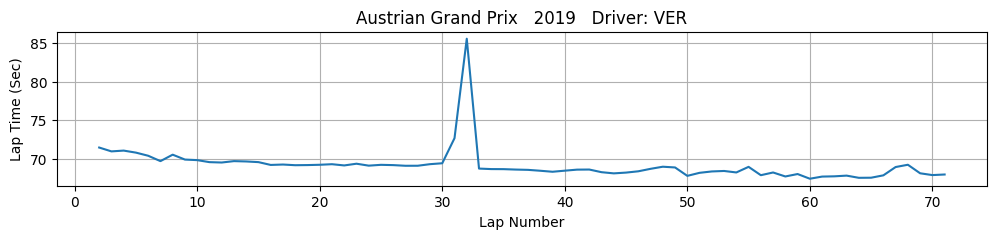

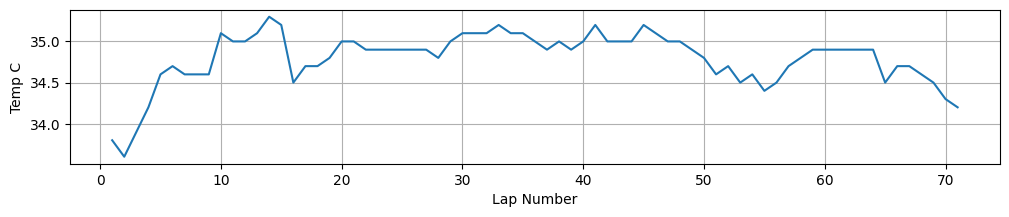

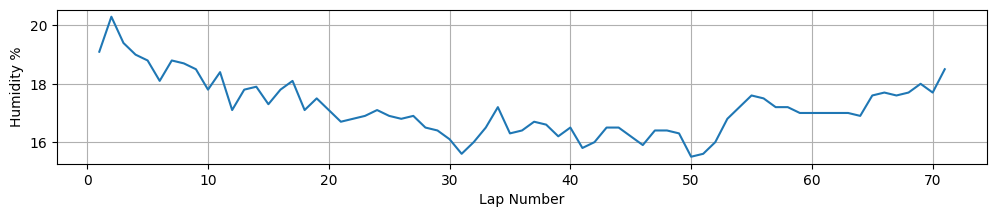

In [32]:
fig = plt.figure(figsize=(12,2))
plt.plot(sub_lap['LapNumber'],sub_lap['lapTimeSec'])
plt.grid()
plt.xlabel('Lap Number')
plt.ylabel('Lap Time (Sec)')
plt.title(sub_lap['EventName'][0]+ '   ' +
          str(sub_lap['eventYear'].values[0])+ '   Driver: ' +
          sub_lap['Driver'][0])

fig = plt.figure(figsize=(12,2))
plt.plot(sub_lap['LapNumber'],sub_lap['AirTemp'])
plt.grid()
plt.xlabel('Lap Number')
plt.ylabel('Temp C')

fig = plt.figure(figsize=(12,2))
plt.plot(sub_lap['LapNumber'],sub_lap['Humidity'])
plt.grid()
plt.xlabel('Lap Number')
plt.ylabel('Humidity %')

plt.show()

In [47]:
def plot_lap_times(df_sub, event,driver, session):   

    
    a = 0 #len(df_sub) - df_sub['lapNumber'][-1:].values[0]
    b = len(df_sub)
    
    Compound = df_sub['Compound'][a:b]
    
    print('Session: ',session, '\n','driver_name', np.unique(df_sub['Driver']),'\n', 
          'Compond: ', np.unique(Compound[Compound.notnull()]))
    
    lapNumber = np.arange(a,b)
    lapTime = df_sub['lapTimeSec']
    plot_laptime = lapTime[a:b]
    lapTime_hat = df_sub['deg_bias']+df_sub['deg_slope']* df_sub['LapNumber']
    lapTime_fuel_corred = df_sub['lapTimeSec'] - df_sub['fuel_slope']*df_sub['LapNumber']
    lapTime_hat_fuel_corred = lapTime_hat - df_sub['fuel_slope']*df_sub['LapNumber']
    fuel_line = df_sub['fuel_slope']*df_sub['LapNumber'] + df_sub['fuel_bias']
    
## charts
    fig = plt.figure(figsize=(15,3))
    plt.plot(df_sub['LapNumber'], lapTime_hat,color='red')
    plt.plot(lapNumber, plot_laptime, color='green')
    plt.plot(lapNumber[df_sub['large_delta_time']],  
             df_sub[df_sub['large_delta_time']]['lapTimeSec'] ,'.',color='black')  
    plt.plot(lapNumber, lapTime_hat_fuel_corred, color='silver')
    plt.plot(lapNumber, lapTime_fuel_corred, color='gray')
    plt.plot(lapNumber, fuel_line, '-', color='tan')
    
### plot labels, title, etc
    top = 105
    bot = np.nanmin( plot_laptime) #plot_laptime
    print('bot: ',bot)
    if (~np.isnan(bot) )&(session!='Qual') :
        plt.ylim(bot,top)
        d = (top-bot)/10

        for ii in range(a,b,5):
            plt.text(ii-1,top-4*d , df_sub['Compound'][ii], fontsize = 10) #np.nanmax(plot_laptime)-5
#             plt.text(ii-1,top-3*d,df_sub['tyres_condition'][ii], fontsize = 10)
            plt.text(ii-1,top-2*d,df_sub['Stint'][ii], fontsize = 10)
#             plt.text(ii-1,top-1*d,df_sub['tyres_type'][ii], fontsize = 10)
        plt.xticks(lapNumber, df_sub['LapNumber'],rotation=45)
        plt.xlabel('LapNumber', fontsize = 16)
        plt.title('event: '+event+',    '+'driver: '+driver, fontsize = 14)
        plt.ylabel(' time', fontsize = 14)
        plt.legend(['stintLapTimeLine','stintLapTime','stintLapTimeLineCorred',
                    'regLinePoints','stintLapTimeCorred','FuelLine'],fontsize = 11)

        plt.grid(visible=True)
        plt.show()
    
    return

Session:  Race 
 driver_name ['VER'] 
 Compond:  ['MEDIUM' 'SOFT']
bot:  86.256


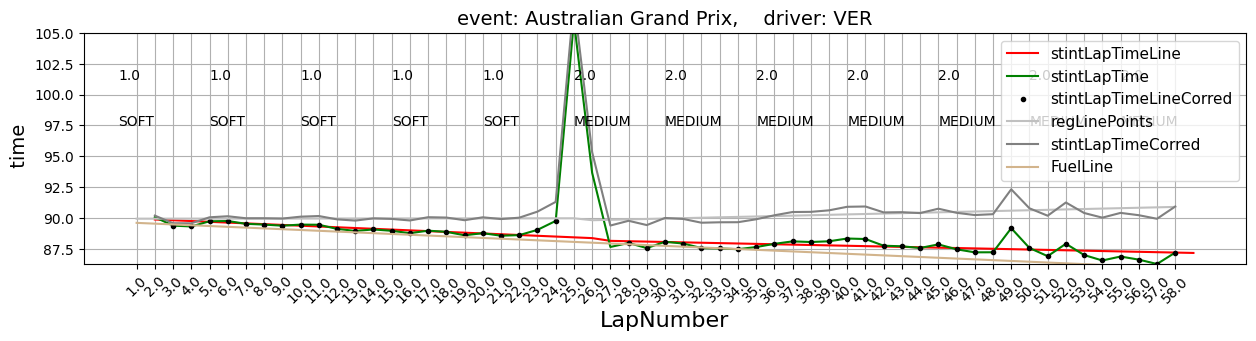

****************************************************************************************************************************************************** 

Session:  Race 
 driver_name ['LEC'] 
 Compond:  ['HARD' 'SOFT']
bot:  86.926


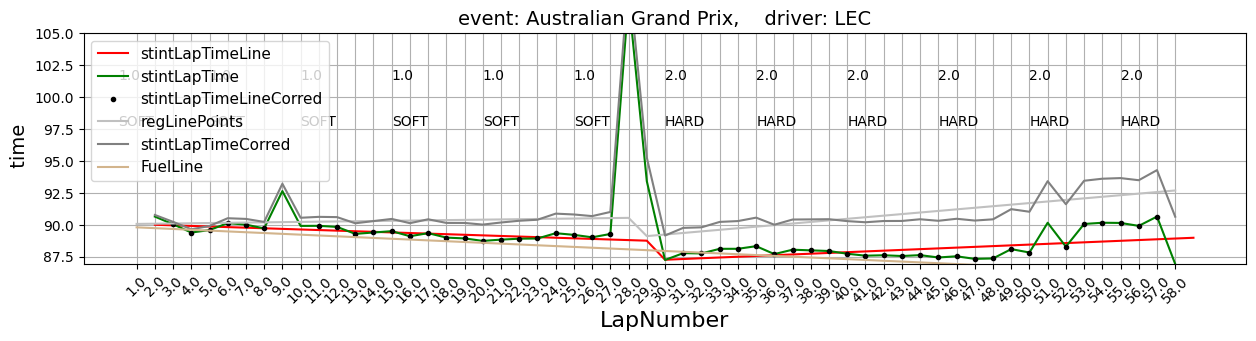

****************************************************************************************************************************************************** 

Session:  Race 
 driver_name ['PER'] 
 Compond:  ['HARD' 'SOFT']
bot:  88.485


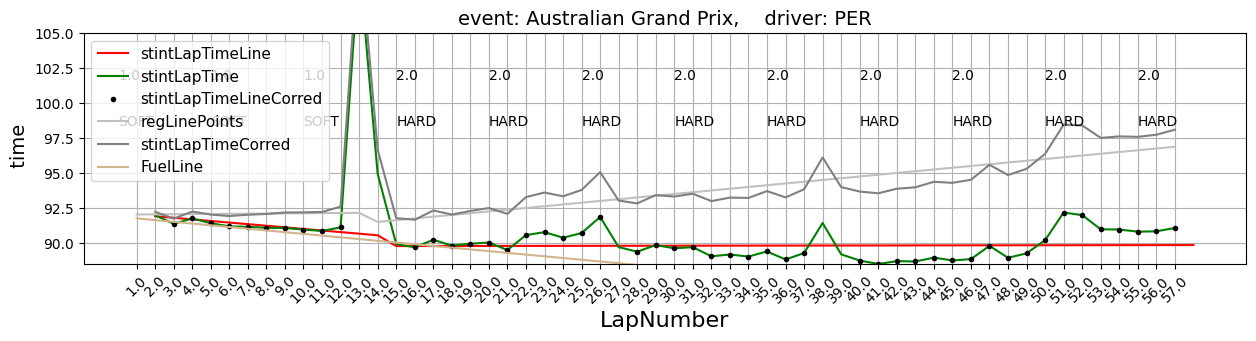

****************************************************************************************************************************************************** 

Session:  Race 
 driver_name ['VER'] 
 Compond:  ['MEDIUM' 'SOFT']
bot:  95.311


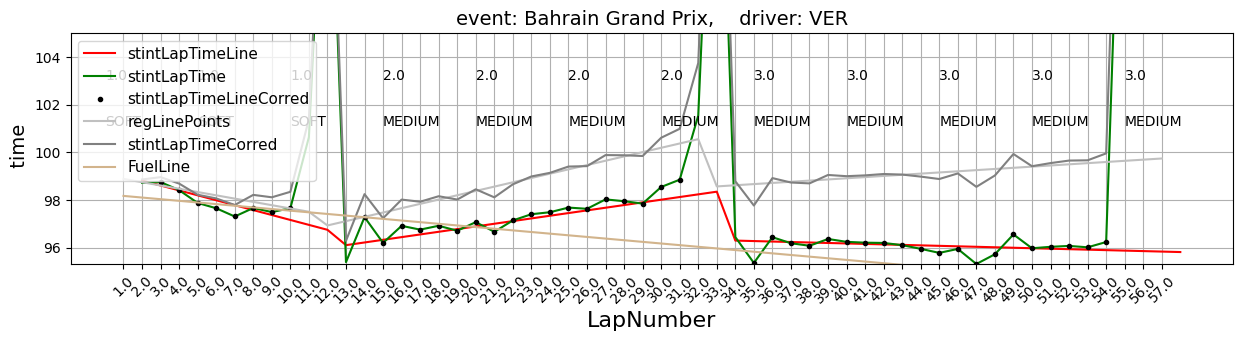

****************************************************************************************************************************************************** 

Session:  Race 
 driver_name ['LEC'] 
 Compond:  ['MEDIUM' 'SOFT']
bot:  93.411


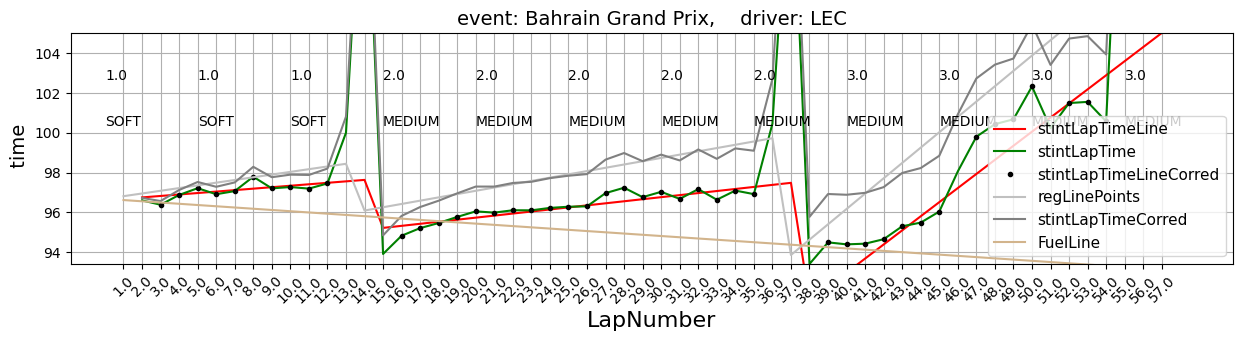

****************************************************************************************************************************************************** 

Session:  Race 
 driver_name ['PER'] 
 Compond:  ['MEDIUM' 'SOFT']
bot:  96.33


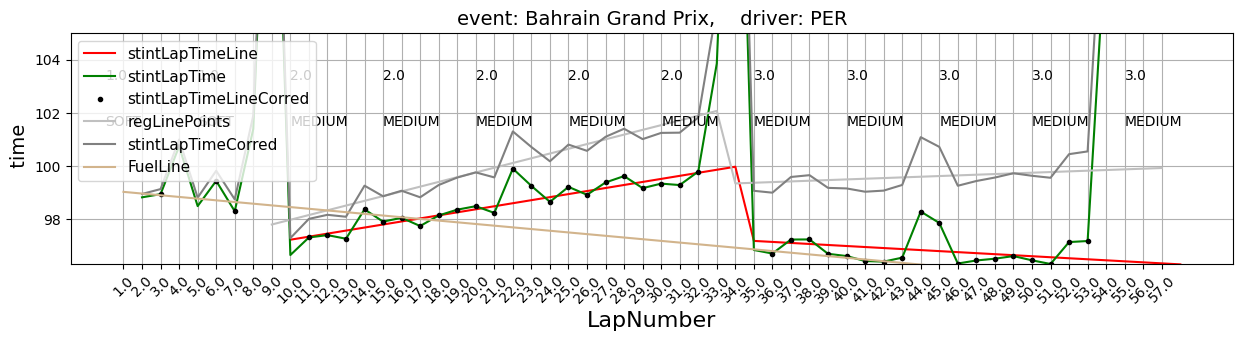

****************************************************************************************************************************************************** 



In [48]:
events = np.unique(df['EventName'])

for evnt in ['Australian Grand Prix', 'Bahrain Grand Prix' ]: #Australian
    drivers = np.unique(df['Driver'][df['EventName']==evnt])
    for drvs in ['VER','LEC','PER']:
        
        sub_df = df[(df['EventName']==evnt) & (df['Driver']==drvs) &  
                    (df['session']=='Race') &(df['eventYear']==2019)].sort_values(by = ['LapNumber']).reset_index(drop=True)
        if len(sub_df):
            plot_lap_times(sub_df,evnt,drvs, 'Race')
            
        print('*' * 150,"\n")

<a id='mergeLinesSlopAndBias'></a>
## Merge lines' slop and bias

In [197]:
df_agg = pd.read_csv('../data/semi_final_data.csv')
df.drop_duplicates(subset=['fuel_slope', 'fuel_bias', 'deg_slope', 'deg_bias'],keep='first',inplace=True)
mergeCols = ['EventName','eventYear','RoundNumber','Driver','Stint','Team', 'fuel_slope', 'fuel_bias', 'deg_slope', 'deg_bias']
dd = df_agg.merge(df[mergeCols], how = 'left', on =['EventName','Team','RoundNumber','eventYear','Driver','Stint'])

### Slopes and bias of current race can not be used as a predictor for the same race
Thus lag features should be included for the current race.

The focus of this project is to predict Length of Stint One and therefore there is no need to normalize for fuel as all drivers starts the race with full tank.
For other Stints we suggest correcting deg_slope based on fuel_slop and before calculating lag features.

Users are encouraged to add any additional lag features here.

In [208]:
def func_create_lag_features(df_sub):
    df_sub = df_sub.sort_values(['EventName','RoundNumber'])
    
    s_m = [np.nan]
    b_m =[np.nan]
    if len(df_sub)>1:
        for ii in range(1,len(df_sub) ):
            s_m.append(np.mean(df_sub[:ii-1]['deg_slope']))
            b_m.append(np.mean(df_sub[:ii-1]['deg_bias'])) #repeating last race is better

    df_sub['lag_slope_mean'] = s_m #df_sub['deg_slope'].rolling(window=2).mean()
    df_sub['lag_bias_mean'] = b_m #df_sub['deg_bias'].rolling(window=2).mean()
    
    return df_sub[['RoundNumber','eventYear','Driver','lag_slope_mean','lag_bias_mean']]

dd1 = dd.groupby(['EventName','Compound','Team', 'Stint']).apply(func_create_lag_features).reset_index().drop('level_4',axis=1)
dd = dd.merge(dd1, on =['EventName','Compound','Team', 'Stint','RoundNumber','eventYear','Driver'])
print('\n','-'*100, '\n','df Length is: ', len(dd), '\n','-'*100)


 ---------------------------------------------------------------------------------------------------- 
 df Length is:  4611 
 ----------------------------------------------------------------------------------------------------


In [199]:
dd.to_csv('../data/final_data.csv')

### End of Merge Data 